# **Tarea 1:** EDA y modelos bayesianos
## **Grupo 5** 
## **Integrantes:** 
 * Diego Irarrazaval
 * Pablo Paredes
 * Tomas Rojas

## Pregunta 1:  Carga y limpieza de datos.
### P1.1

In [820]:
import pandas as pd
import glob as glob
import numpy as np

`files_raw`, `files_estadisticas` y `files_asignacion` son listas que contienen las direcciones donde se encuentran los .csv a leer. 

In [821]:
files_raw = glob.glob('data/raw/**/*.csv', recursive = True)
files_estadisticas = glob.glob('data/estadisticas_upz/*.csv')
files_asignacion = glob.glob('data/asignacion_upz/*.csv')

data_raw = ([pd.read_csv(dir) for dir in files_raw])

### Creación del DataFrame y reporte de archivos furnished

In [822]:
'''
Creamos un data frame 'furnished', el cual tendrá dos columnas
1) 'url' para hacer el merge finalmente y obtener el data frame requerido
2) 'furnished' para contar cuantos datos están en archivos furnished y no en archivos all
'''

data_all = []
data_fur = []

for i in [0,2,4,6,8]:
    
    df1 = pd.read_csv(files_raw[i])
    df2 = pd.read_csv(files_raw[i+1])
    
    data_all.append(df1)
    data_fur.append(df2)
    
df_all = pd.concat(data_all)
df_fur = pd.concat(data_fur)
    
f1 = pd.merge(df_all, df_fur, how='outer', on='url', indicator='furnished')
furnished = f1[['url', 'furnished']].copy()

furnished.drop_duplicates(inplace = True)
furnished.reset_index(drop=True, inplace=True)

# Se reportan si hay datos de archivos furnished que no estén en all 

print('Hay '+ str(len(furnished[furnished['furnished'] == 'right_only'])) + ' datos de archivos furnished que no estan en all')

Hay 4 datos de archivos furnished que no estan en all


In [823]:
'''
Creamos el data frame 'data'
'''

df_aux = pd.concat([df_all, df_fur], ignore_index=True)

data = pd.merge(df_aux, furnished, how='inner', on='url')
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

# Se elimina la columna 'furnished' y se quitan los duplicados

data.drop('furnished', axis=1, inplace=True)
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

### P1.2 Limpieza de Columnas 

In [824]:
'''
Limpieza de columnas 'price', 'surface', 'n_rooms', 'n_bath'
'''

# Columna de precio ('price') tipo float

data.price = data['price'].str.replace('.', '')
data.price = data['price'].str.strip('$')
data.price = data['price'].map(float)

# Columna de área ('surface') tipo float

data.surface = data['surface'].replace('m2', '', regex=True)
data.surface = data['surface'].map(float)

In [825]:
# Notamos que en la columna de dormitorios ('n_rooms') existe la opción '5+'
# por lo que dejaremos esta columna como categórica

data.n_rooms.unique()

array(['3', 3.0, '5', '4', '2', '1', nan, 5.0, 4.0, '5+', 2.0, 1.0],
      dtype=object)

In [826]:
# Se crea un diccionario para pasar los datos numéricos de 'n_rooms' a string
# y se efectúa el mapeo

dic = {1.0: '1', 2.0:'2', 3.0: '3', 4.0:'4', 5.0:'5'}

data.n_rooms = data['n_rooms'].replace(dic)

In [827]:
# Como habían datos que solo se diferenciaban en la cantidad de dormitorios
# por el tipo de dato que eran (float o int), puede haberse creado duplicados. Se borran nuevamente los duplicados
# de data

data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [828]:
# Se hace lo mismo con la columnna de cantidad de baños ('n_bath')

data.n_bath.unique()

array(['2', 2.0, '1', '4', '3', nan, 3.0, '5', 4.0, 5.0, '5+', 1.0],
      dtype=object)

In [829]:
dic = {1.0: '1', 2.0:'2', 3.0: '3', 4.0:'4', 5.0:'5'}

data.n_bath.replace(dic)
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

In [830]:
'''
Separación de columna property_tipe|rent_type|location en tres columnas
con los nombres respectivos

'''

# Renombramos la columna

data.columns = ['PTL', 'price', 'n_rooms', 'n_bath', 'surface', 'details', 'url', 'metrocuadrado_index']

In [831]:
# Creamos las columnas y las llenamos

col = data['PTL'].str.split(', ', expand=True)

meta_col = col[0].str.split(' en ', expand=True)

# Nos aseguramos que hayan solo las siguientes opciones:
# -> 'Casa', 'Apartamento' para property_type
# -> 'Arriendo', 'Venta Y Arriendo' para rent_type

print(meta_col[0].unique())
print(meta_col[1].unique())

['Casa' 'Apartamento']
['Arriendo' 'Venta Y Arriendo']


In [832]:
# Formamos las nuevas columnas 'property_type', 'rent_type', 'location'

data['property_type'] = meta_col[0] 
data['rent_type'] = meta_col[1]
data['location'] = col[1]

# y retiramos la columna PTL

data.drop('PTL', axis=1, inplace=True)

In [833]:
# Finalmente quitamos la ciudad de 'location'

loc = col[1].str.split(' Bogotá', expand=True)
data.location = loc[0]

### P1.3 Precio por metro cuadrado y Cantidad de garages

In [834]:
'''
Agregamos una columna que represente el precio por metro cuadrado 'price_per_m2'

'''

#data['price_per_m2'] = (data['price'][i]/data['surface'][i] if data['surface'][i] > 0 else float('nan') for i in range(len(data['surface'])))

data['price_per_m2'] = np.where(data['surface'] <= 0, float('nan'), data['price']/data['surface'])


In [835]:
'''
Obtenemos la cantidad de garajes y lo agregamos como columna también 'cant_garajes'

'''

garajes_list = data.url.str.split('-garajes', expand=True)
garajes_num = garajes_list[0].str.rsplit('-', n=1, expand=True)

# indices que tienen urls con info de la cantidad de garajes
ind = garajes_list[1].index[garajes_list[1].isna() == False]

# generación de nueva columna para después asignarla a la data
garajes_list[2] = np.nan
garajes_list[2].loc[ind] = garajes_num[1].loc[ind]

# agregación de la cantidad de garajes a la data (nan si no hay info)
data['cant_garajes'] = garajes_list[2]

### P1.4 Clasificación Tipo de Producto

In [836]:
'''
Creamos una nueva columna 'clasif_prod_type' donde se representará la clasificación
de la vivienda con dígitos del 1 al 8 de acuerdo al enunciado

'''

data['clasif_prod_type'] = np.nan

data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 80) & (data.surface < 120)] = 1
data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 120) & (data.surface < 180)] = 2
data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 180) & (data.surface < 240)] = 3
data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 240) & (data.surface < 360)] = 4
data.clasif_prod_type.loc[(data.property_type == 'Casa') & (data.surface >= 360) & (data.surface < 460)] = 5
data.clasif_prod_type.loc[(data.property_type == 'Apartamento') & (data.surface >= 40) & (data.surface < 60)] = 6
data.clasif_prod_type.loc[(data.property_type == 'Apartamento') & (data.surface >= 60) & (data.surface < 80)] = 7
data.clasif_prod_type.loc[(data.property_type == 'Apartamento') & (data.surface >= 80) & (data.surface < 120)] = 8

data['clasif_prod_type'].astype('category')

0        NaN
1        1.0
2        1.0
3        1.0
4        NaN
        ... 
18386    6.0
18387    1.0
18388    6.0
18389    7.0
18390    8.0
Name: clasif_prod_type, Length: 18391, dtype: category
Categories (8, float64): [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

### P1.5 Obtención del código UPZ

In [837]:
'''
Se carga el archivo y se guarda en un dataframe data_upz
Luego, se realiza el merge para obtener el código para cada barrio

'''

# Se guarda la base de datos en un data frame
data_upz = pd.read_csv(files_asignacion[0], usecols = ['UPlCodigo', 'pro_location', 'UPlArea'])

# Se deja todo en minuscula para poder hacer el merge correctamente
data_upz.pro_location = data_upz.pro_location.map(str).map(lambda s: s.lower())
data.location = data.location.map(lambda s: s.lower())

In [838]:
#Se realiza el merge y se reportan cuantos datos no fueron asignados con código UPZ

data_merge = pd.merge(data, data_upz, left_on='location', right_on='pro_location', how='left')

print('A ' + str(sum(data_merge.UPlCodigo.isna())) + ' datos no se les puede asignar código UPZ')
print('lo cual es ' + str(sum(data_merge.UPlCodigo.isna())/len(data)*100) + '% de los datos')

A 2059 datos no se les puede asignar código UPZ
lo cual es 11.195693545756075% de los datos


In [839]:
# Creamos la columna 'UPZ' en data y le asignamos el código UPZ obtenido en data_merge

data['UPZ'] = data_merge['UPlCodigo']
data['UPZ_area'] = data_merge['UPlArea']

### P1.6 Fusión de datos con código UPZ

In [840]:
'''
Se cargan los datos en distintos data frames, para después hacerles merge con data
Luego, se crea una columna de densidad poblacional para cada código UTZ

'''

# Se cargan los datos en data frames respectivamente

data_pobl = pd.read_csv(files_estadisticas[0])
data_inseg = pd.read_csv(files_estadisticas[1])
data_verde = pd.read_csv(files_estadisticas[2])

In [841]:
# Se quitan las columnas innecesarias de data_pobl y data_inseg

data_pobl.drop(['Unnamed: 0', 'nomupz'], axis=1, inplace=True)
data_inseg.drop(['Unnamed: 0', 'UPlNombre2'], axis=1, inplace=True)

In [842]:
# En data_verde se tiene que al código UPZ viene solo el número
# por lo tanto, hay que transformarlo al formato UPZ + número para poder hacer el merge correctamente

col = data_verde.cod_upz.map(int).map(str)
col_upz = 'UPZ' + col

data_verde.cod_upz = col_upz

# Se eliminan las columnas innecesarias
data_verde.drop(['Unnamed: 0', 'upz'], axis=1, inplace=True)

In [843]:
# Se realiza el merge, eliminando después las columnas innecesarias

data = pd.merge(data, data_pobl, left_on='UPZ', right_on='upz', how='left')
data.drop('upz', axis=1, inplace=True)
data = pd.merge(data, data_inseg, left_on='UPZ', right_on='UPlCodigo', how='left')
data.drop('UPlCodigo', axis=1, inplace=True)
data = pd.merge(data, data_verde, left_on='UPZ', right_on='cod_upz', how='left')
data.drop('cod_upz', axis=1, inplace=True)

In [844]:
# Finalmente, se crea la columna de densidad de población para cada código UTZ ('UTZ_density')

data['UTZ_density'] = data.personas/data.UPZ_area

## P2. EDA
### P2.1 Creacion de `estilo()`

In [845]:
import seaborn as sns
import matplotlib.pyplot as plt
#se crea diccionario que dará los valores a setear por defecto en el notebook
custom = {
    "font.size": 12,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 20,
    "axes.linewidth": 1.25,
    "grid.linewidth": 1,
    "lines.linewidth": 1.5,
    "lines.markersize": 6,
    "patch.linewidth": 1,
    "xtick.major.width": 1.25,
    "ytick.major.width": 1.25,
    "xtick.minor.width": 1,
    "ytick.minor.width": 1,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 4,
    "ytick.minor.size": 4,
    'figure.figsize':(10.,8.),
    "figure.facecolor": "white",
    "axes.labelcolor": ".15",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.color": ".15",
    "ytick.color": ".15",
    "axes.axisbelow": True,
    "grid.linestyle": "--",
    "text.color": ".1",
    "patch.force_edgecolor": True,
    "image.cmap": "RdBu_r",
    "xtick.top": False,
    "ytick.right": False,
         }

#En las siguiente línea se implementa el diccionario personalizado como default para este notebook en seaborn
sns.set(rc=custom)

#se escoge una de las paletas que vienen con seaborn 
#(distinta a la que se usa por defecto) para el resto de notebook.
#sns.set_palette('Set2')

### P2.2 Perfilamiento: 
#### Naturaleza de las variables:
Antes del perfilamiento se hara un estudio de la naturaleza de las variables y se observaran algunas columnas 
para mejor entendimiento de los datos. 
Adicionalmente a estos estudios, se realizo lo siguiente:
```
import pandas_profiling as pp
pp.ProfileReport(data)

profile = data.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="output.html")
```
No se incluye en el notebook por el tipo de output que genera y debido a que tiene un largo tiempo de ejecucion. 

En primer lugar, es importante conocer que tipos de datos tienen las variables (o columnas).

In [846]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18393 entries, 0 to 18392
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   price                                    18393 non-null  float64
 1   n_rooms                                  18359 non-null  object 
 2   n_bath                                   18164 non-null  object 
 3   surface                                  18393 non-null  float64
 4   details                                  18275 non-null  object 
 5   url                                      18393 non-null  object 
 6   metrocuadrado_index                      18393 non-null  float64
 7   property_type                            18393 non-null  object 
 8   rent_type                                18393 non-null  object 
 9   location                                 18393 non-null  object 
 10  price_per_m2                             18377

Para comprender mejor las variables, se visualizan las primeras 5 filas con `head()`:

In [847]:
data.head()

,price,n_rooms,n_bath,surface,details,url,metrocuadrado_index,property_type,rent_type,location,...,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad,areas_verdes_perc,UTZ_density
0,1050000.0,3,2,63.0,Excelente casa cerca de la calle 80 y Avenida ...,https://www.metrocuadrado.com/inmueble/arriend...,25.6,Casa,Arriendo,la soledad norte,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3930000.0,3,2,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,Casa,Arriendo,ciudad salitre sur-oriental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3930000.0,3,2,100.0,Se arrienda casa bonita totalmente amoblada co...,https://www.metrocuadrado.com/inmueble/arriend...,57.3,Casa,Arriendo,ciudad salitre sur-oriental,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,750000.0,3,1,90.0,CASA DE TRES NIVELES TRES ALCOBAS SALA COMEDOR...,https://www.metrocuadrado.com/inmueble/arriend...,12.2,Casa,Arriendo,villa de los alpes ii sector,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3400000.0,5,4,71.0,casa ezquinera excelente ubicacion cinco alcob...,https://www.metrocuadrado.com/inmueble/arriend...,56.0,Casa,Arriendo,paris gaitan,...,156375.0,1.1,0.8,12.6,71.1,37.073314,8.40636,1.02916,37.852289,0.041894


Para ayudar a entender las variables numericas:

In [848]:
data.describe()

,price,surface,metrocuadrado_index,price_per_m2,clasif_prod_type,UPZ_area,personas,trabajoinf_ninos_5_17_anos_perc,trabajoinfampliado_ninos_5_17_anos_perc,jovenes_14_24_anos_nini_perc,indice_envegecimiento,jefe_mujer_perc,adultos_mayores_pobres_perc,indice_inseguridad,areas_verdes_perc,UTZ_density
count,1.839300e+04,18393.000000,18393.00000,1.837700e+04,15493.000000,1.633400e+04,16334.000000,16334.000000,16334.000000,16334.000000,16334.000000,16334.000000,16334.000000,16334.000000,16334.000000,16334.000000
mean,8.916470e+06,114.312981,53.74343,9.788351e+04,6.179436,4.096954e+06,89179.774091,0.765881,15.286703,8.968501,106.355443,40.474601,7.951293,3.583395,32.323209,0.021656
std,1.339971e+08,110.109799,13.94925,1.532783e+06,1.753186,1.557667e+06,62329.384892,0.902056,24.499691,6.158096,45.982085,4.345747,6.795396,4.954806,14.286564,0.011396
min,0.000000e+00,0.000000,0.00000,0.000000e+00,1.000000,8.532359e+05,11570.000000,0.000000,0.100000,4.100000,9.800000,26.367889,1.034990,0.000000,5.274501,0.005101
25%,1.700000e+06,57.000000,44.30000,2.272727e+04,6.000000,2.851990e+06,52951.000000,0.000000,2.000000,4.300000,76.600000,38.443910,3.840225,1.161103,20.901367,0.012534
50%,2.600000e+06,77.000000,54.00000,3.134328e+04,7.000000,4.224476e+06,81261.000000,0.400000,7.900000,5.500000,127.300000,39.741321,5.401917,2.047782,25.466350,0.018877
75%,4.000000e+06,122.000000,63.40000,4.142857e+04,7.000000,4.745042e+06,115124.000000,1.500000,17.000000,11.400000,153.400000,44.667815,9.439051,3.383459,40.289476,0.025098
max,7.800000e+09,7400.000000,100.00000,5.494203e+07,8.000000,7.565953e+06,370385.000000,3.500000,125.700000,33.600000,153.400000,47.033692,50.669819,84.444444,86.427053,0.073815


#### Agrupacion por naturaleza:
A continuacion, se grafican las variables para entender como se distribuyen. Para esto, separamos las variables categoricas de las numericas. Ademas, debido a que las variables `'details','url','UPZ','location'` tienen muchos valores distintos, se dejaran en una categoria aparte:

In [849]:
names = ['numeric', 'categorical']

categorical = [col for col in data.columns if data[col].dtype == 'O']

others = ['details','url','UPZ','location']

numeric = list(set(data.columns) - set(cat_vars) - set(['clasif_prod_type']))

categorical += set(['clasif_prod_type'])
for col in others:
    categorical.remove(col)

mapping = [('numeric', col) for col in numeric]
mapping.extend([('categorical', col) for col in categorical])
mapping.extend([('others', col) for col in others])
'''
Se reordenan las columnas del dataframe para que coincidan con el esquema 
del multi indice
'''

data = data.reindex(columns = numeric + categorical + others)

#### Graficos de distribuciones univariadas de las variables:
Para esto, se implementan dos funciones: `plot_numeric_vars` y `plot_categorical_vars`. 

In [850]:
#Funcion para graficar Distribuciones univariadas de variables numericas:
def plot_numeric_vars(df, columns, title):
    '''
    Creaciion de graficos de Distribuciones Univariadas, recibe 
    el dataframe, las columnas a graficar y el 'SuperTitulo'    
    
    Args:
    ----------
    columns: list
        Lista con los nombres de las columnas de tipo numerico a graficar. 
        
    title: String
        Titulo
        
    Returns: None
        Se muestran los graficos
    
    
    Ejemplo de uso: 
    ------------
    
    Dado un DataFrame df:
    col_a_graficar = ['col1','col2','col3']
    
    plot_uni_dist(df,col_a_graficar,'Grafico de variables 1, 2, 3')
    
    '''
    
    nplots = len(columns)
    ncols = 3
    nrows = int(np.ceil(nplots/ncols))
    
    # Grilla de subplots
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[17, 17])

    #Veamos si se deben remover plot:
    if nplots - ncols*nrows > 0:
        r = -(nplots - ncols*nrows)
        list(map(lambda a : a.remove(), ax[-1,r:]))
    
    fig.tight_layout()
    
    #Ponemos el titulo:
    fig.suptitle(title,
             fontsize=20,
             x=0.5,
             y=1.05)
    
    #Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
    #distinto en funcion del tipo de dato.
    for axis, col in zip(ax.flatten(), columns):
        try :
            # Graficos para datos numericos
            sns.distplot(df[(col)], ax=axis, rug=True)

        except RuntimeError:
            sns.distplot(df[(col)], ax=axis, rug=True, kde=False)

        axis.set_xlabel(col, fontsize=15)

    # Se ajusta el espaciado interno entre subplots
    w, h = (.4, .4)
    plt.subplots_adjust(wspace=w, hspace=h)
    
    

In [851]:
#Funcion para graficar Distribuciones univariadas de variables numericas:
def plot_categorical_vars(df, columns, title, order = dict()):
    '''
    Creaciion de graficos de Distribuciones Univariadas recibe
    el dataframe, las columnas a graficar y el 'SuperTitulo'    
    
    Args:
    ----------
    columns: list
        Lista con los nombres de las columnas de tipo numerico a graficar. 
        
    title: String
        Titulo
        
    order: dict
        Diccionario que contiene como llave el nombre de la columna que se desea ordenar 
        y como valor una lista con las categorias correspondientes a esa columna en el orden 
        deseado. 
        
    Returns: None
        Se muestran los graficos
        
        
    Ejemplo de uso: 
    -------------
    Dado un DataFrame df:
    col_a_graficar = ['col1','col2','col3']
    cat_order = {
         'col1' = ['cat1','cat2','cat3', 'cat4']
         'col2' = [i for i in range(1,11)]
         'col3' = ['mujer', 'hombre', 'otro']
    }
    plot_uni_dist(df,col_a_graficar,'Grafico de variables categoricas', cat_order)
    -----------------
    
    Cuando no se incluye un diccionario order, se ordena por defecto. 
    
    
    '''
    
    nplots = len(columns)
    ncols = 3
    nrows = int(np.ceil(nplots/ncols))
    
    # Grilla de subplots
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)#, figsize=[17, 17])

    #Veamos si se deben remover plot:
    if nplots - ncols*nrows > 0:
        r = -(nplots - ncols*nrows)
        list(map(lambda a : a.remove(), ax[-1,r:]))
    
    fig.tight_layout()
    
    #Ponemos el titulo:
    fig.suptitle(title,
             fontsize=20,
             x=0.5,
             y=1.05)
    '''
    Se recorre cada axis, para cada columna del dataframe, se genera un grafico 
    distinto en funcion del tipo de dato.

    '''
    for axis, col in zip(ax.flatten(), columns):    
        # Graficos para datos tipos str
        try:
            sns.countplot(df[(col)], ax=axis, order = order[col])
        except:
            sns.countplot(df[(col)], ax=axis)
        axis.set_axis_on()
        axis.set_title(col, fontsize=15)
  
    
    # Se ajusta el espaciado interno entre subplots
    h, w = (.8, .8)
    plt.subplots_adjust(wspace=w, hspace=h)

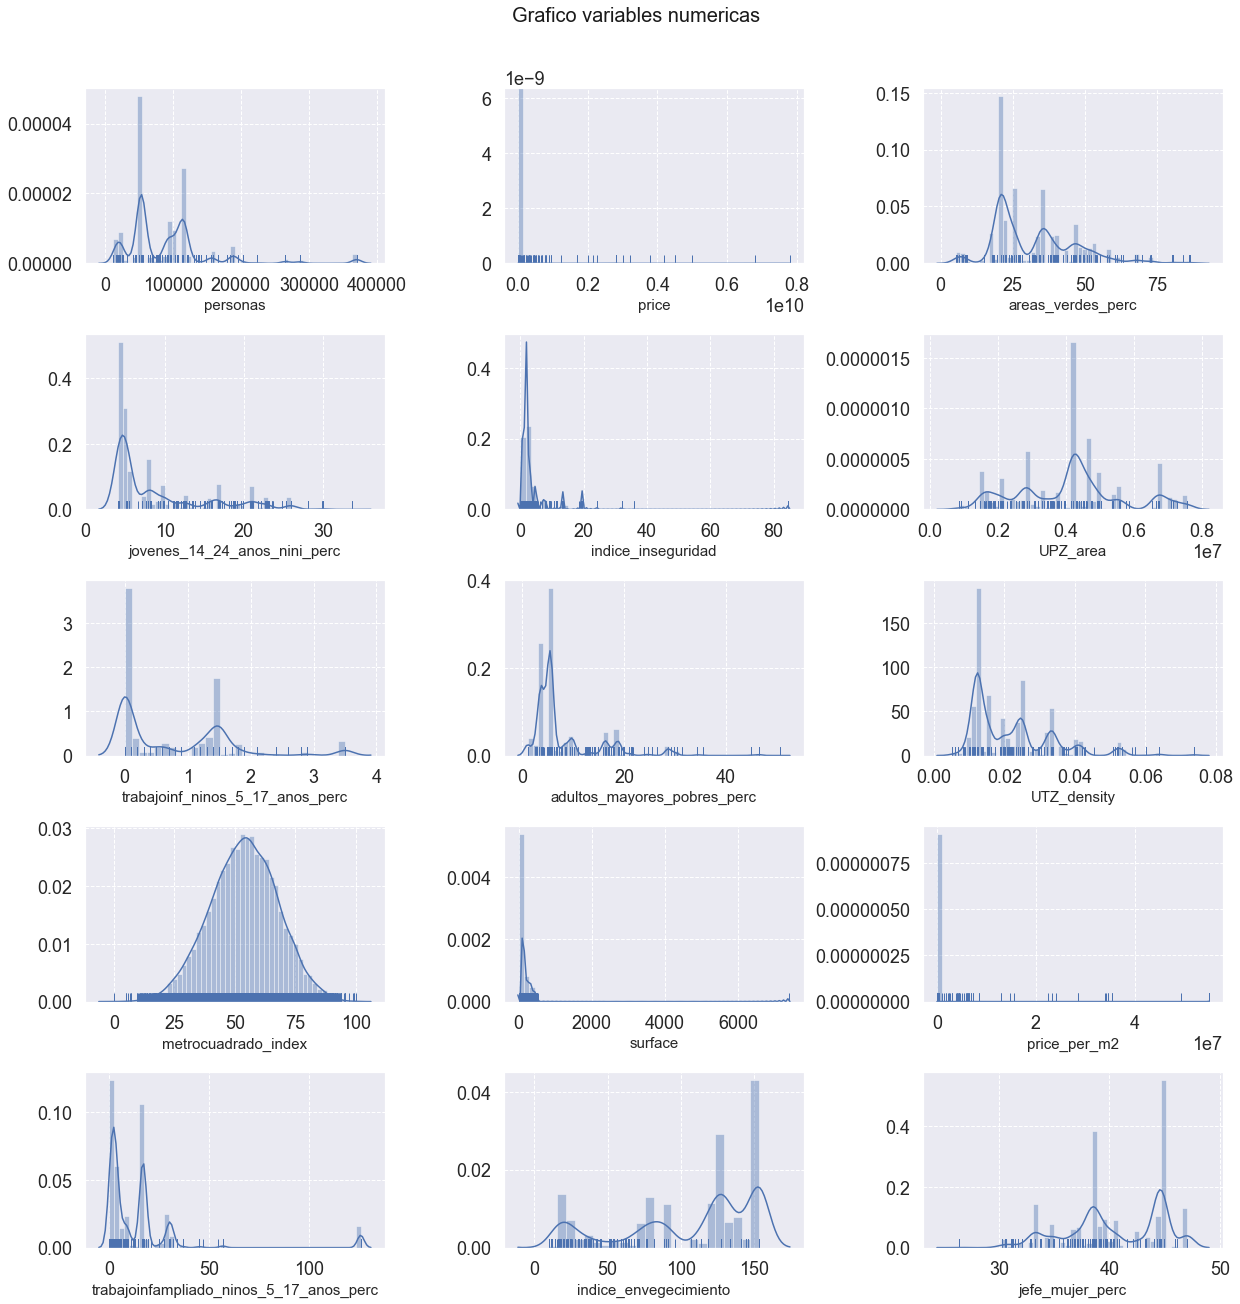

In [852]:
plot_uni_dist(data,numeric,'Grafico variables numericas')

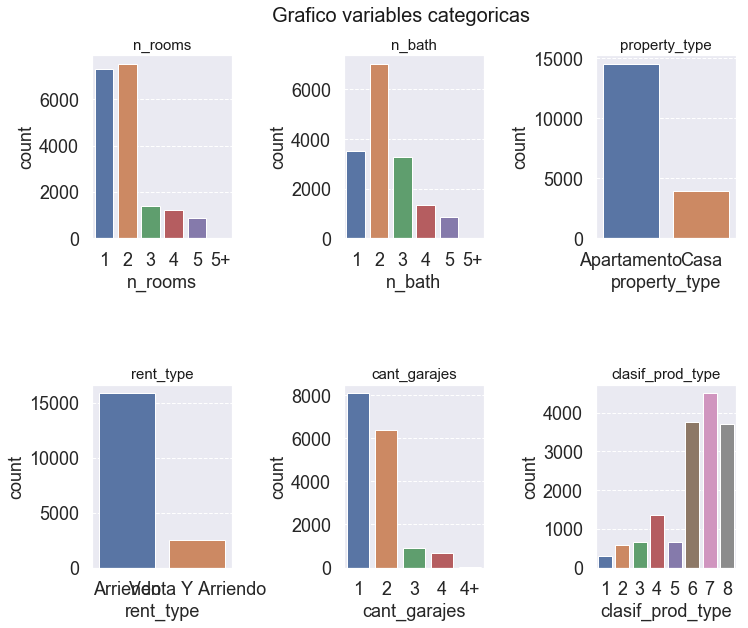

In [853]:
plot_order = {'n_rooms': [ '1', '2', '3', '4', '5', '5+'],
              'n_bath': [ '1', '2', '3', '4', '5', '5+'],
              'property_type': ['Apartamento', 'Casa'],
              'rent_type': ['Arriendo', 'Venta Y Arriendo'],
              'cant_garajes': ['1', '2', '3', '4', '4+'],
              'clasif_prod_type': [i for i in range(1,9)]
             }
plot_categorical_vars(data,categorical,'Grafico variables categoricas',plot_order)
#len(categorical)

In [854]:
data[others].describe()

,details,url,UPZ,location
count,18275,18393,16334,18393
unique,14613,14992,100,632
top,"Lindo apartamento de 1 alcoba, interior pero c...",https://www.metrocuadrado.com/inmueble/arriend...,UPZ97,chico norte
freq,22,8,3898,942


Como la variable _target_ es el precio cuadrado por metro cuadrado, a continuacion se implementa una funcion para Estudiar como se relacionan estas variables. Para las variables categoricas, el tipo de grafico utilizado es el boxplot o el grafico de violin. Para las variables numericas se utiliza el _scatter plot_. Dado el rango de precio por $metro^2$, es importante que exista la opcion de escalar el eje y.

In [855]:
def plot_violin(target, col, scale = True ,df = data):

    # Sirve para fija el tamaño de lasetiquetas del plot
    fontdict = {'fontsize':20}

    # Estrucutra de figura y axes
    fig, ax = plt.subplots(2,1,figsize=[12,13])

    # violin plot --> equivalente a catplot(kind = 'violin')
    if scale:
        sns.violinplot(col,
                    y=(target),
                    data=df,
                    kind='violin',
                    ax=ax[0]).set_yscale("log")
    else:
        sns.violinplot(col,
            y=(target),
            data=df,
            kind='violin',
            ax=ax[0])

    sns.countplot(df[col], ax=ax[1])

    ax[0].set_xlabel(col, fontdict)
    ax[1].set_xlabel(col, fontdict)

    ax[0].set_ylabel(target, fontdict)
    title = 'Violin plot ' + col + ' v/s ' + target
    ax[0].set_title(title, fontdict)
    title_y = "Frecuencias " + col
    ax[1].set_title(title_y, fontdict)
    

    h, w = (.3, .1)
    plt.subplots_adjust(wspace=w, hspace=h)

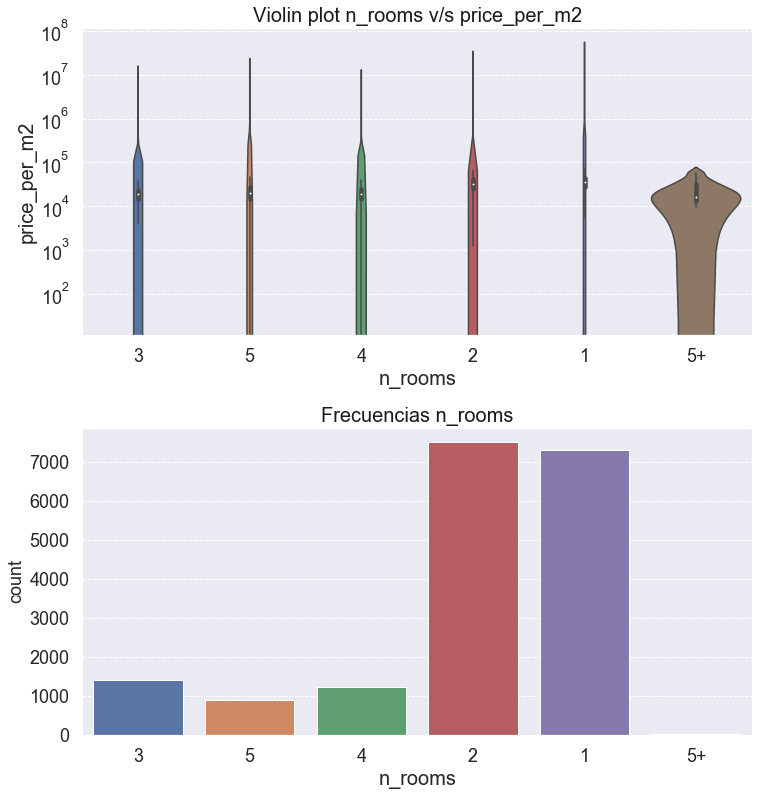

In [856]:
plot_violin('price_per_m2','n_rooms')

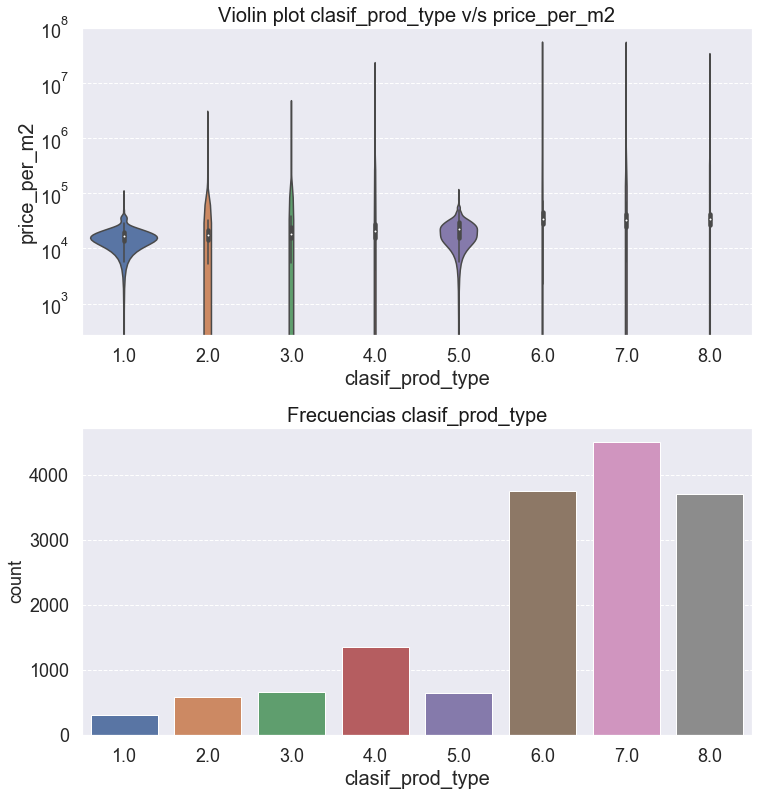

In [857]:
plot_violin('price_per_m2','clasif_prod_type')

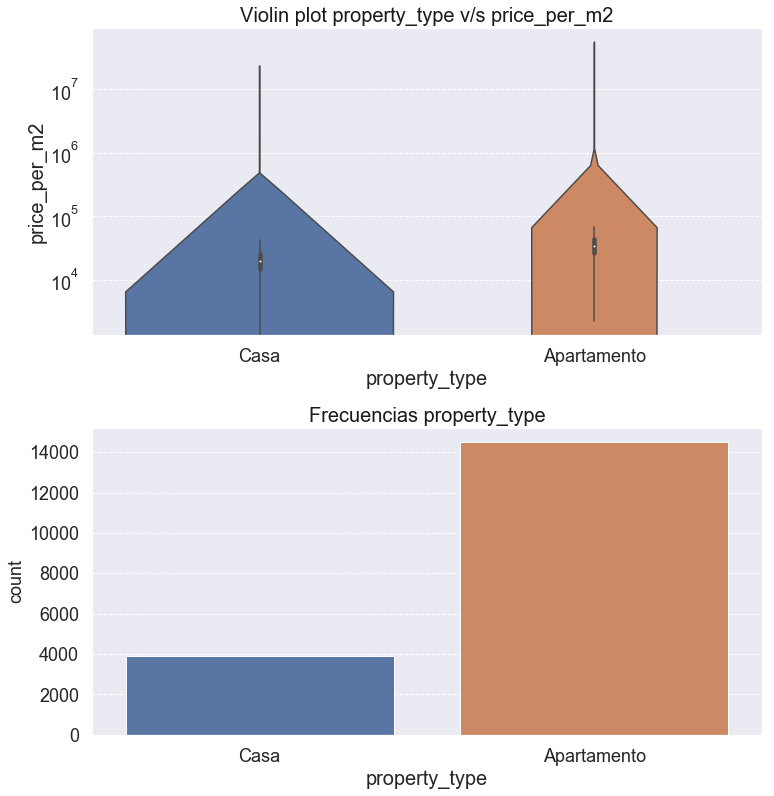

In [858]:
plot_violin('price_per_m2','property_type')

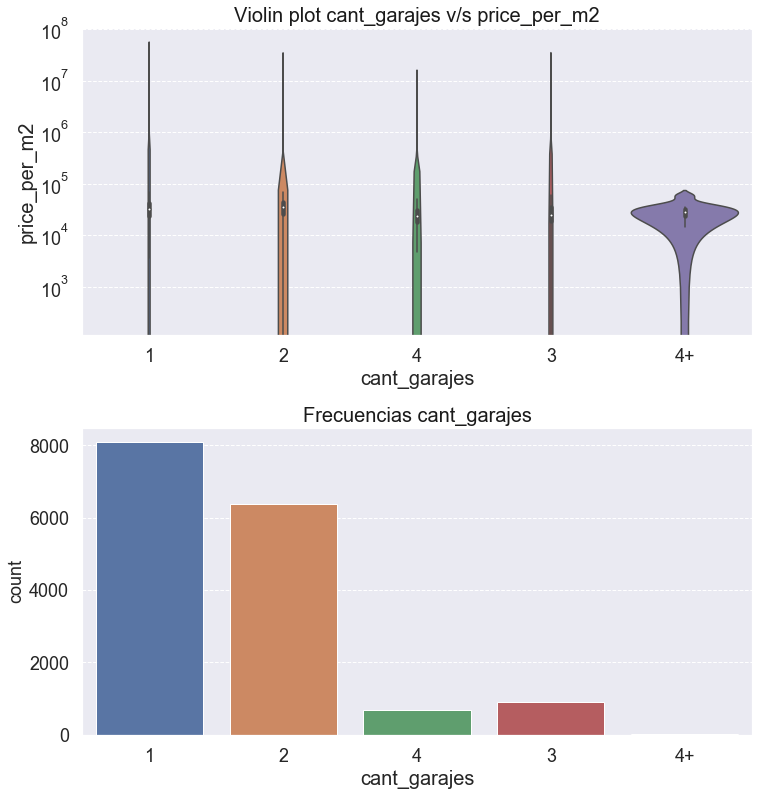

In [859]:
plot_violin('price_per_m2','cant_garajes')

Para entender como se relacionan las variables entre ellas, es de utilidad el mapa de calor:

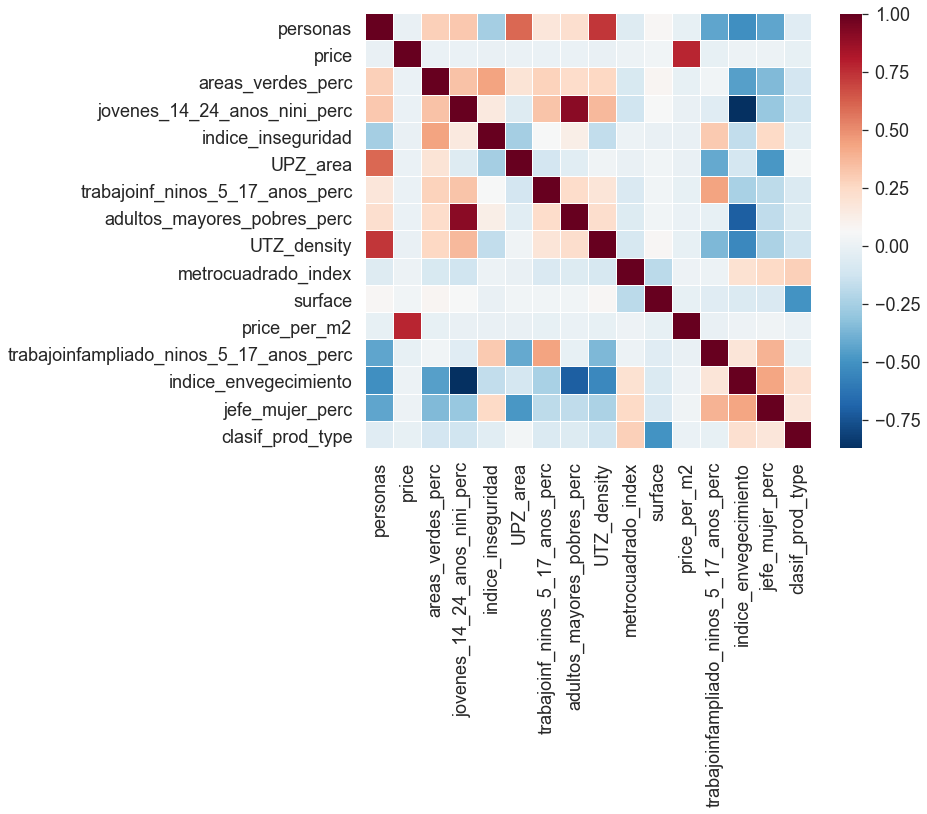

In [861]:
sns.heatmap(data.corr(), linewidths=.01, cmap = 'RdBu_r')